<font size="+3"><mark>Limitations of SAX-like methods / The means per segment do not come from a normal distribution</mark></font>

# Introduction

## README

_Associated GitHub repository: https://github.com/sylvaincom/astride._

This notebook investigates the normality assumption on the means per (uniform) segment.

It focuses on the 86 data sets that are used in the classification benchmark.

## Configuration parameters

In [1]:
IS_COMPUTE = True
IS_EXPORT_DF = True
IS_SAVE_FIG = True

DATE_EXP = "2023_02_08"

## Imports

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm
from datetime import timedelta
from time import time
import plotly.express as px
import plotly.figure_factory as ff

import ruptures as rpt
from scipy.spatial.distance import euclidean
from scipy.stats import normaltest, shapiro
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.utils import Bunch
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

from src.metadata import l_datasets_classif_bench
from src.segment_feature import SegmentFeature
from src.segmentation import Segmentation
from src.symbolic_signal_distance import SymbolicSignalDistance
from src.symbolization import Symbolization
from src.utils import load_ucr_dataset, create_path
from src.utils_gaussian_assumption import run_gaussian_assumption, explore_dataset_means

In [3]:
cwd = Path.cwd()
sns.set_theme()
plt.rcParams['figure.figsize'] = (10, 3)

# Define the data sets

In [4]:
l_datasets = l_datasets_classif_bench.copy()

In [5]:
print(len(l_datasets))

86


# Launch the statistical test for all data sets

In [6]:
%%time

if IS_COMPUTE:
    d_segment_features_df = dict()
    d_normality_test = dict()
    print_bool = False

    for (i, dataset_name_ucr) in enumerate(tqdm(l_datasets)):
        b_get_means_per_segments = run_gaussian_assumption(
            dataset_name_ucr=dataset_name_ucr,
        )
        d_segment_features_df[dataset_name_ucr] = b_get_means_per_segments.segment_features_df
        d_normality_test[dataset_name_ucr] = [
            b_get_means_per_segments.n_samples,
            b_get_means_per_segments.n_segments,
            b_get_means_per_segments.p_value,
            b_get_means_per_segments.res_H0
        ]

100%|██████████| 86/86 [03:12<00:00,  2.24s/it]

CPU times: user 3min 5s, sys: 4.08 s, total: 3min 9s
Wall time: 3min 12s


# Explore final results

## Process results

In [7]:
if IS_COMPUTE:
    df_normality_test = (
        pd.DataFrame.from_dict(d_normality_test, orient='index')
        .reset_index().rename(columns={
            "index":"dataset",
            0:"n_samples",
            1:"n_segments",
            2:"p_value",
            3:"normality_assumption"
        })
    )
    display(df_normality_test.head())

if IS_EXPORT_DF:
    folder = cwd / f"results/{DATE_EXP}"
    create_path(folder)
    df_normality_test.to_csv(folder / "normality_test.csv", index=False)

,dataset,n_samples,n_segments,p_value,normality_assumption
0,Adiac,176,32,0.000000e+00,rejected
1,ArrowHead,251,32,0.000000e+00,rejected
2,Beef,470,64,2.584412e-15,rejected
3,BeetleFly,512,64,5.286344e-33,rejected
4,BirdChicken,512,64,2.231850e-14,rejected


In [8]:
# Load the computed data
df_normality_test = pd.read_csv(cwd / f"results/{DATE_EXP}/normality_test.csv")

In [9]:
pvalue_na = df_normality_test["p_value"].isna().sum()
print(f"There are {pvalue_na} data sets with a NaN p-value.")

print("\nThese (eventual) data sets are the following:")
display(df_normality_test[df_normality_test["p_value"].isna()])

print("\nPercentage of data sets that respect the normality assumption or not (beware of NaNs):")
display(df_normality_test["normality_assumption"].value_counts() / len(df_normality_test) * 100)

There are 0 data sets with a NaN p-value.

These (eventual) data sets are the following:


,dataset,n_samples,n_segments,p_value,normality_assumption



Percentage of data sets that respect the normality assumption or not (beware of NaNs):


rejected    100.0
Name: normality_assumption, dtype: float64

<mark>All data sets are rejected!</mark>

In [10]:
if IS_COMPUTE:
    
    l_segment_features_df = []
    for key, value in d_segment_features_df.items():
        dataset_name_ucr = key
        segment_features_df = value
        segment_features_df["dataset"] = dataset_name_ucr
        l_segment_features_df.append(segment_features_df)
    all_segment_features_df = pd.concat(l_segment_features_df)

    l_columns = ["dataset"] + [elem for elem in all_segment_features_df.columns.tolist() if elem != "dataset"]
    all_segment_features_df = all_segment_features_df[l_columns]

    display(all_segment_features_df.sample(5))

if IS_EXPORT_DF:
    folder = cwd / f"results/{DATE_EXP}"
    create_path(folder)
    all_segment_features_df.to_csv(folder / "all_segment_features_df.csv", index=False)

,dataset,mean_feat,signal_index,segment_start,segment_end,segment_length
75051,NonInvasiveFetalECGThorax1,-0.636919,1172,503,514,11
128724,MixedShapesSmallTrain,-0.936167,2011,319,335,16
74652,NonInvasiveFetalECGThorax2,-0.711779,1166,327,339,12
135032,StarLightCurves,0.048068,2109,895,911,16
36911,InlineSkate,-0.754936,576,1381,1410,29


In [11]:
# Load the computed data
all_segment_features_df = pd.read_csv(cwd / f"results/{DATE_EXP}/all_segment_features_df.csv")

## Explore results

For the Strawberry data set, there are 0.0% of NaN mean values.


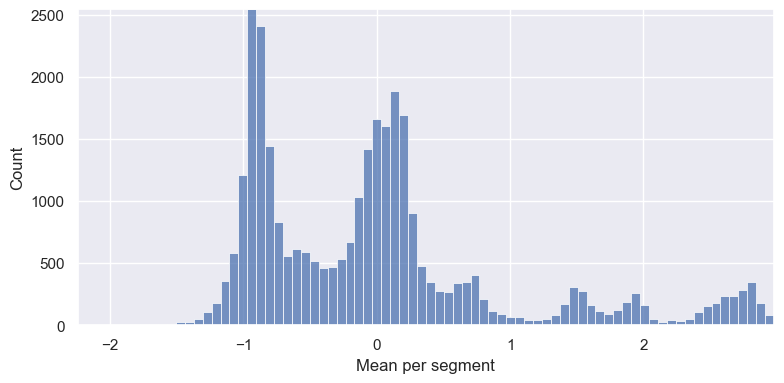

,dataset,n_samples,n_segments,p_value,normality_assumption
49,Strawberry,235,32,0.0,rejected


In [12]:
explore_dataset_means(
    dataset_name_ucr="Strawberry",
    all_segment_features_df=all_segment_features_df,
    df_normality_test=df_normality_test,
    is_save_fig=True,
    date_exp=DATE_EXP,
)

*Note*: This corresponds to Figure 2 of the paper.